Find similar light curves using kernel distances

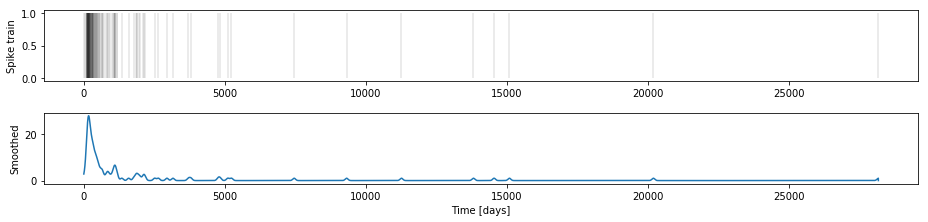

In [5]:
#http://elephant.readthedocs.io/en/latest/_modules/elephant/statistics.html#fftkernel
#https://pdfs.semanticscholar.org/d516/a1cf9110963bf50898d3918bae30cbce61a4.pdf
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from astropy.io import fits
from tqdm import tqdm_notebook
import pickle

def get_light_curve(file_name, no_phase=True):
    with fits.open(file_name) as hdul:
        events = hdul[1].data
    times = np.sort(events['time'])
    if no_phase:
        times = times - times[0]
    return times

def kde_spike(times, sigma=1, resolution=1):
    times_grid = np.arange(times[0], times[-1], step=resolution)
    smooth_times = np.zeros(shape=times_grid.shape)
    for center in times:
        min_idx = np.argmin((times_grid - center + 5*sigma)**2)
        max_idx = np.argmin((times_grid - center - 5*sigma)**2)
        smooth_times[min_idx:max_idx] += np.exp(-0.5*(times_grid[min_idx:max_idx] - center)**2/sigma**2)
    #smooth_times = smooth_times*np.sqrt(2.0*np.pi)*sigma*len(times)
    return times_grid, smooth_times

times = get_light_curve('/home/phuijse/Data/XRAY/cut_evt2.fits')
tgrid, smoothed_lc = kde_spike(times, sigma=50, resolution=1)
fig = plt.figure(figsize=(13, 3))
ax = fig.add_subplot(2, 1, 1)
ax.vlines(times, ymin=0.0, ymax=1.0, alpha=0.1)
ax.set_ylabel('Spike train')
ax = fig.add_subplot(2, 1, 2)
ax.plot(tgrid, smoothed_lc)
plt.tight_layout()
ax.set_ylabel('Smoothed')
ax.set_xlabel('Time [days]');

In [2]:
from os import listdir
from os.path import join

# Light curves
lc_path = "/home/phuijse/Data/XRAY/CSCVAR/"
file_list = [file for file in sorted(listdir(lc_path)) if file[-13:] == '_regevt3.fits']

## Schoenberg kernel

A spike train is a sequence of ordered spike times $\mathcal{S}^{(i)} = \{t_m \in [0, T]: m \in 0, \ldots, M\}$ which can be viewed as a realization of a stochastic point process defined by its conditional intesity function $ \lambda(t|H_t^{(i)})$ with $t\in [0,T]$ and $H_t^{(i)}$ the history of the process $i$ up to $t$.

The Schoeberg kernel is a universal binless kernel that compares the conditional intensity functions
\begin{equation}
\kappa(\lambda_i, \lambda_j) = \exp \left ( -\alpha \int [\lambda(t|H_t^{(i)}) - \lambda(t|H_t^{(j)})]^2 \,dt \right) ,
\end{equation}

with parameter $\alpha > 0$. In this case we approximate the conditional intensity function as
\begin{equation}
\widehat \lambda(t) = \sum_{m=1}^M g(t-t_m),
\end{equation}
*i.e.* the spike times convolved with a smoothing kernel (e.g. Laplacian, Gaussian).

If the smoothing function takes this simple form $g(t)= \frac{1}{\mathcal{T}}  (U(t) - U(t-\mathcal{T}))$, then the integral reduces to $\sum_m (t_m^{(i)} - t_m^{(j)})^2$


1. https://www.frontiersin.org/articles/10.3389/fnins.2018.00194/full
1. https://arxiv.org/pdf/1302.5964.pdf
1. http://www.sci.utah.edu/~arpaiva/pubs/2010b.pdf


In [3]:
tau = 10.0
overlap = 10
T = 5e+3 # times_template[-1]

times_template = get_light_curve('/home/phuijse/Data/XRAY/cut_evt2.fits')
K_template = np.sum(np.exp(-np.absolute(times_template[times_template < T, np.newaxis] \
                                        - times_template[times_template < T, np.newaxis].T)/tau))/(2*tau)

In [ ]:
distances = list()
lc_index = list()
for k in tqdm_notebook(range(len(file_list)), 'LC'):
    times = get_light_curve(join(lc_path, file_list[k]))
    time_span = times[-1]  # Assume template is shorter than lc
    N_windows = int(overlap*(time_span - T)/T)    
    if N_windows < 1:
        continue
    lc_index.append(k)    
    K_cross = np.zeros(shape=(N_windows,))
    K_sig = np.zeros(shape=(N_windows,))
    K_time = np.zeros(shape=(N_windows,))
    K_points = np.zeros(shape=(N_windows,))
    for i in range(N_windows):
        K_time[i] = i*T/overlap
        init_point = np.argmin((times - K_time[i])**2)
        end_point = np.argmin((times - K_time[i] - T)**2)
        window_t = times[init_point:end_point] - times[init_point]
        K_points[i] = len(window_t)
        K_sig[i] = np.sum(np.exp(-np.absolute(window_t[:, np.newaxis] - window_t[:, np.newaxis].T)/tau))/(2*tau)
        K_cross[i] = np.sum(np.exp(-np.absolute(times_template[times_template < T, np.newaxis] \
                                                 - window_t[:, np.newaxis].T)/tau))/(2*tau)
    distances.append(np.stack((K_time, K_points, K_sig, K_cross)))
    
pickle.dump([lc_index, file_list, K_template, distances], open("xray_distances.p", "wb"), protocol=2)   

In [6]:
lc_index, file_list, K_template, distances = pickle.load(open("xray_distances.p", "rb"))

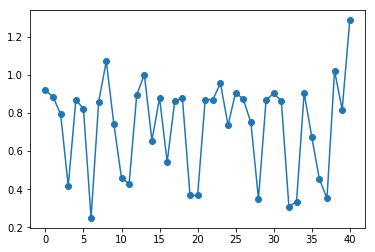

In [7]:
min_distance = np.zeros(shape=(len(distances),))

def dist_function(idx):
    K_time, K_points, K_sig, K_cross = distances[idx]
    valid_idx = np.where(K_points > 50)[0]
    d= -np.log(K_cross[valid_idx]) + 0.5*np.log(K_sig[valid_idx]) + 0.5*np.log(K_template) 
    #d = -K_cross[valid_idx]/K_points[valid_idx] + 0.5*K_sig[valid_idx]/K_points[valid_idx] + 0.5*K_template/110
    #d = -2*K_cross[valid_idx]/(110*K_points[valid_idx]) + K_sig[valid_idx]/K_points[valid_idx]**2 +K_template/110**2
    #d = -2*K_cross[valid_idx] + K_sig[valid_idx] +K_template
    return K_time[valid_idx], d

for i in range(len(distances)):
    _, D = dist_function(i)
    min_distance[i] = np.amin(D)
    
plt.plot(min_distance, '-o')

27


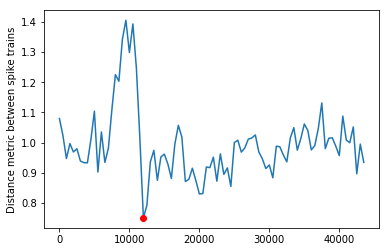

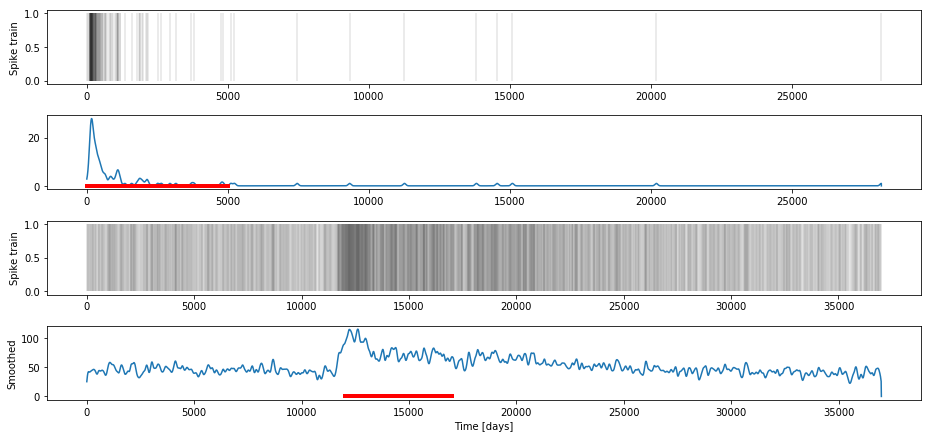

In [8]:
file_idx = 27
print(file_idx)
K_time, D = dist_function(file_idx)
best = np.argmin(D)
plt.plot(K_time, D)
plt.plot(K_time[best], D[best], 'ro')
plt.ylabel('Distance metric between spike trains')

tgrid, smoothed_lc = kde_spike(times_template, sigma=50, resolution=1)
fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(4, 1, 1)
ax.vlines(times_template, ymin=0.0, ymax=1.0, alpha=0.1)
ax.set_ylabel('Spike train')
ax = fig.add_subplot(4, 1, 2)
ax.plot(tgrid, smoothed_lc)
plt.plot([times_template[0], times_template[0] + T], 
         [np.amin(smoothed_lc), np.amin(smoothed_lc)], 'r', linewidth=4)

times = get_light_curve(join(lc_path, file_list[lc_index[file_idx]]))
selection = (times > K_time[best]-5*T) & (times < K_time[best]+5*T)
tgrid, smoothed_lc = kde_spike(times[selection], sigma=50, resolution=10)
ax = fig.add_subplot(4, 1, 3)
ax.vlines(times[selection], ymin=0.0, ymax=1.0, alpha=0.01)
ax.set_ylabel('Spike train')
ax = fig.add_subplot(4, 1, 4)
ax.plot(tgrid, smoothed_lc)
plt.plot([K_time[best], K_time[best] + T], 
         [np.amin(smoothed_lc), np.amin(smoothed_lc)], 'r', linewidth=4)
plt.tight_layout()
ax.set_ylabel('Smoothed')
ax.set_xlabel('Time [days]');